In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime
from sklearn.model_selection import train_test_split
import re
import pickle
from spacytextblob.spacytextblob import SpacyTextBlob
import en_core_web_md
from xgboost import XGBClassifier

%matplotlib inline
plt.style.use('ggplot')

In [3]:
nlp = en_core_web_md.load()
spacy_text_blob = SpacyTextBlob()
nlp.add_pipe(spacy_text_blob)

#check if stock price went up today
def is_stock_up(row):
    return True if row[1] < row[4] else False

    
def get_sentiment(body):
    doc = nlp(body)
    return doc._.sentiment.polarity

def get_subjectivity(body):
    doc = nlp(body)
    return doc._.sentiment.subjectivity

#clean the open price such that it uses the previous day closing price
def clean_open(open_price,close_price):
    open_price = list(open_price)
    close_price = list(close_price)
    cleanned_prices = [open_price[0]]
    cleanned_prices.extend(close_price[:-1])
    return cleanned_prices

#shift the dataframes down to get the stock movement tomorrow
def rotate_df_series(movements):
    first_half = movements[1:]
    second_half = movements[0]
    first_half.append(second_half)
    return first_half

#remove row without next day movement
def remove_last_row(df):
    row = df.iloc[-1].name
    return df.drop(row)
    
    

In [3]:
df = pd.read_csv('cleaned_wsb_sample.csv')

In [4]:
df = df.drop('Unnamed: 0',axis=1)

In [9]:
#Covert to New York Stock exchange timezone
df.created_utc = pd.DatetimeIndex(data=df.created_utc,tz='Etc/Universal')

In [13]:
df['sentiment'] = df.body.apply(get_sentiment)

In [14]:
df['subjectivity'] = df.body.apply(get_subjectivity)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11180899 entries, 0 to 11180898
Data columns (total 5 columns):
 #   Column        Dtype                        
---  ------        -----                        
 0   body          object                       
 1   created_utc   datetime64[ns, Etc/Universal]
 2   token_length  int64                        
 3   sentiment     float64                      
 4   subjectivity  float64                      
dtypes: datetime64[ns, Etc/Universal](1), float64(2), int64(1), object(1)
memory usage: 426.5+ MB


In [16]:
df.head()

,body,created_utc,token_length,sentiment,subjectivity
0,We’re retarded and claim to be often. If you l...,2020-03-25 08:11:50+00:00,17,-0.8000,0.800
1,markets been open for 13 min...,2020-03-25 08:11:45+00:00,6,0.0000,0.500
2,Spy can fuck around all it wants just as long ...,2020-03-25 08:11:41+00:00,20,-0.0625,0.275
3,"you lost me at ""bulls fucked""",2020-03-25 08:11:36+00:00,6,-0.6000,0.700
4,I wonder if the same people who short TSLA but...,2020-03-25 08:11:35+00:00,19,-0.1200,0.465


In [18]:
df['created_utc'] = df['created_utc'].apply(lambda timestamp : timestamp.tz_convert('US/Eastern'))

In [40]:
df['date_string'] = df['created_utc'].dt.strftime('%Y-%m-%d')

In [56]:
#Feature engineering to see the effect Month has on stock movement
df['month'] = df['created_utc'].dt.strftime('%B')

In [38]:
#Feature engineering to see the effect day of week has on stock movement
df['day_of_week'] = df['created_utc'].dt.strftime('%A')

In [80]:
df.to_csv('cleaned_wsb_sample.csv')

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11180899 entries, 0 to 11180898
Data columns (total 8 columns):
 #   Column        Dtype                     
---  ------        -----                     
 0   body          object                    
 1   created_utc   datetime64[ns, US/Eastern]
 2   token_length  int64                     
 3   sentiment     float64                   
 4   subjectivity  float64                   
 5   date_string   object                    
 6   day_of_week   object                    
 7   month         object                    
dtypes: datetime64[ns, US/Eastern](1), float64(2), int64(1), object(4)
memory usage: 682.4+ MB


In [60]:
#group dataframe by day
count = df.groupby(['date_string','day_of_week','month'])['body'].count()

In [61]:
count

date_string  day_of_week  month   
2018-02-17   Saturday     February      133
2018-02-18   Sunday       February      564
2018-02-19   Monday       February      572
2018-02-20   Tuesday      February      626
2018-02-21   Wednesday    February      536
                                      ...  
2021-02-12   Friday       February    32549
2021-02-13   Saturday     February    12548
2021-02-14   Sunday       February     4206
2021-02-15   Monday       February    11814
2021-02-16   Tuesday      February     5022
Name: body, Length: 1035, dtype: int64

In [68]:
#get mean sentiment per day
sentiment = df.groupby(['date_string','day_of_week','month'])['sentiment'].mean()
subjectivity = df.groupby(['date_string','day_of_week','month'])['subjectivity'].mean()

In [104]:
sent_df = pd.DataFrame(sentiment)
subj_df = pd.DataFrame(subjectivity)
count_df = pd.DataFrame(count)

In [105]:
sent_df = sent_df.reset_index(level=[0,1,2])
subj_df = subj_df.reset_index(level=[0,1,2,])
count_df = count_df.reset_index(level=[0,1,2])

In [106]:
#join dataframes together
combined_df = pd.merge(sent_df,subj_df, on='date_string')
combined_df = pd.merge(combined_df,count_df,on='date_string')
combined_df.head()

,date_string,day_of_week_x,month_x,sentiment,day_of_week_y,month_y,subjectivity,day_of_week,month,body
0,2018-02-17,Saturday,February,-0.008260,Saturday,February,0.383118,Saturday,February,133
1,2018-02-18,Sunday,February,0.046003,Sunday,February,0.344501,Sunday,February,564
2,2018-02-19,Monday,February,0.059630,Monday,February,0.342871,Monday,February,572
3,2018-02-20,Tuesday,February,0.036545,Tuesday,February,0.353234,Tuesday,February,626
4,2018-02-21,Wednesday,February,0.042253,Wednesday,February,0.335483,Wednesday,February,536


In [107]:
#drop uneeded columns
combined_df = combined_df.drop(['day_of_week_x','day_of_week_y','month_x','month_y'],axis=1)
combined_df.head()

,date_string,sentiment,subjectivity,day_of_week,month,body
0,2018-02-17,-0.008260,0.383118,Saturday,February,133
1,2018-02-18,0.046003,0.344501,Sunday,February,564
2,2018-02-19,0.059630,0.342871,Monday,February,572
3,2018-02-20,0.036545,0.353234,Tuesday,February,626
4,2018-02-21,0.042253,0.335483,Wednesday,February,536


In [110]:
#rename colmns for readability
combined_df = combined_df.rename(mapper={'body':'comment_count'},axis=1)
combined_df.head()

,date_string,sentiment,subjectivity,day_of_week,month,comment_count
0,2018-02-17,-0.008260,0.383118,Saturday,February,133
1,2018-02-18,0.046003,0.344501,Sunday,February,564
2,2018-02-19,0.059630,0.342871,Monday,February,572
3,2018-02-20,0.036545,0.353234,Tuesday,February,626
4,2018-02-21,0.042253,0.335483,Wednesday,February,536


In [113]:
combined_df['day_of_week'] = pd.Categorical(combined_df['day_of_week'])
combined_df['month'] = pd.Categorical(combined_df['month'])
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1035 entries, 0 to 1034
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   date_string    1035 non-null   object  
 1   sentiment      1035 non-null   float64 
 2   subjectivity   1035 non-null   float64 
 3   day_of_week    1035 non-null   category
 4   month          1035 non-null   category
 5   comment_count  1035 non-null   int64   
dtypes: category(2), float64(2), int64(1), object(1)
memory usage: 75.5+ KB


In [39]:
combined_df.to_csv('training_data.csv')

In [40]:
combined_df = pd.read_csv('training_data.csv')
combined_df = combined_df.drop('Unnamed: 0',axis=1)
combined_df['day_of_week'] = pd.Categorical(combined_df['day_of_week'])
combined_df['month'] = pd.Categorical(combined_df['month'])
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   date_string    1035 non-null   object  
 1   sentiment      1035 non-null   float64 
 2   subjectivity   1035 non-null   float64 
 3   day_of_week    1035 non-null   category
 4   month          1035 non-null   category
 5   comment_count  1035 non-null   int64   
dtypes: category(2), float64(2), int64(1), object(1)
memory usage: 35.2+ KB


In [41]:
#clean stock dataframes
stocks = ['SP500.csv','GME.csv','BB.csv','AMC.csv','NOK.csv','PLTR.csv','TSLA.csv']
df_stocks = []
for stock in stocks:
    df_stocks.append(pd.read_csv(stock))
    
filtered_stocks = []
for frame in df_stocks:
    frame.Date = pd.DatetimeIndex(data=frame.Date)
    filtered_stocks.append(frame[frame.Date >= datetime(2018, 2, 15)]) 
df_stocks = []
for frame in filtered_stocks:
    frame.Date = pd.DatetimeIndex(data=frame.Date,tz='US/Eastern')
    df_stocks.append(frame)
    
for frame in df_stocks:
    frame['up_today'] = frame.apply(is_stock_up,axis=1)

In [43]:
for frame in df_stocks:
    frame['Open'] = clean_open(frame.Open,frame.Close)

In [44]:
i = 0
for frame in df_stocks:
    frame['pct_change'] = -(frame['Open'] - frame['Close']) / frame['Open']

In [45]:
cleanned_frames[0]

,Date,Open,High,Low,Close,Adj Close,Volume,up_today,pct_change,up_tomorrow
113,2018-02-15 00:00:00-05:00,2713.46,2731.51,2689.82,2731.20,2731.20,3.684910e+09,True,0.006538,True
114,2018-02-16 00:00:00-05:00,2731.20,2754.42,2725.11,2732.22,2732.22,3.637460e+09,True,0.000373,False
115,2018-02-20 00:00:00-05:00,2732.22,2737.60,2706.76,2716.26,2716.26,3.627610e+09,False,-0.005841,False
116,2018-02-21 00:00:00-05:00,2716.26,2747.75,2701.29,2701.33,2701.33,3.779400e+09,False,-0.005497,False
117,2018-02-22 00:00:00-05:00,2701.33,2731.26,2697.77,2703.96,2703.96,3.701270e+09,False,0.000974,True
...,...,...,...,...,...,...,...,...,...,...
894,2021-03-25 00:00:00-04:00,3889.14,3919.54,3853.50,3909.52,3909.52,4.940800e+09,True,0.005240,True
895,2021-03-26 00:00:00-04:00,3909.52,3978.19,3917.12,3974.54,3974.54,5.467850e+09,True,0.016631,True
896,2021-03-29 00:00:00-04:00,3974.54,3981.83,3943.25,3971.09,3971.09,4.619840e+09,True,-0.000868,False
897,2021-03-30 00:00:00-04:00,3971.09,3968.01,3944.35,3958.55,3958.55,4.103570e+09,False,-0.003158,True


In [46]:
cleanned_frames = []
for frame in df_stocks:
    movements = list(frame.up_today)
    tomorrow = rotate_df_series(movements)
    frame['up_tomorrow'] = tomorrow
    frame = remove_last_row(frame)
    cleanned_frames.append(frame)


In [47]:
for frame in df_stocks:
    frame['date_string'] = frame['Date'].dt.strftime('%Y-%m-%d')
    frame['day_of_week'] = frame['Date'].dt.strftime('%A')
    frame['month'] = frame['Date'].dt.strftime('%B')
    

In [48]:
for frame in df_stocks:
    frame['pct_volatility'] = (frame['High'] - frame['Low']) / frame['Low']

In [49]:
for frame in df_stocks:
    frame.drop(['Date','Adj Close'],axis=1, inplace=True)

In [50]:
testing_frames = []
for frame in df_stocks:
    testing_frames.append(frame.merge(combined_df))

In [51]:
#get dummines on the dataframes
i = 0
for frame in testing_frames:
    
    frame['day_of_week'] = pd.Categorical(frame['day_of_week'])
    frame['month'] = pd.Categorical(frame['month'])
    testing_frames[i] = pd.get_dummies(frame, columns=['day_of_week','month'], drop_first=True)
    i += 1
    
testing_frames[0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 748 entries, 0 to 747
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Open                   748 non-null    float64
 1   High                   748 non-null    float64
 2   Low                    748 non-null    float64
 3   Close                  748 non-null    float64
 4   Volume                 748 non-null    float64
 5   up_today               748 non-null    bool   
 6   pct_change             748 non-null    float64
 7   up_tomorrow            748 non-null    bool   
 8   date_string            748 non-null    object 
 9   pct_volatility         748 non-null    float64
 10  sentiment              748 non-null    float64
 11  subjectivity           748 non-null    float64
 12  comment_count          748 non-null    int64  
 13  day_of_week_Monday     748 non-null    uint8  
 14  day_of_week_Thursday   748 non-null    uint8  
 15  day_of

In [52]:
#contain variables in a class to prevent declaring too many variables

class StockDataClassification():   
    
    def __init__(self, df):
        self.model = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.score = None
        self.X = df.drop(['up_tomorrow','date_string'],axis=1)
        self.y = df['up_tomorrow']
        
    def get_train_test_split(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size = 0.2, random_state = 42)
        
    def train_model(self, model):
        self.model = model
        self.model = self.model.fit(self.X_train, self.y_train)
        
    def get_model_results(self):
        self.score = self.model.score(self.X_test,self.y_test)
        return self.score
    
    def get_model_improvement(self):
        return self.score - self.y.mean()
    
    def get_feature_importances(self):
        return self.model.feature_importances_

In [53]:
#training data on XGBOOST
stocks = ['SP500','GME','BB','AMC','NOK','PLTR','TSLA']
i = 0
results_dict = {}
for frame in testing_frames:
    stock_classification = StockDataClassification(frame)
    stock_classification.get_train_test_split()
    stock_classification.train_model(XGBClassifier(use_label_encoder=False))
    results = stock_classification.get_model_results()
    improvement = stock_classification.get_model_improvement()
    feature_importances = stock_classification.get_feature_importances()
    results_dict[stocks[i]] = [results,improvement,feature_importances]
    i += 1

[00:29:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:29:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:29:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:29:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [54]:
#print results
i = 0
accuracy_results = []
for key in results_dict:
    print('''For stock {stock}, the model accuracy is {results}, 
The improvement over the baseline model is {improvement}'''.format(
        stock=stocks[i],
        results=results_dict[stocks[i]][0],
        improvement=results_dict[stocks[i]][1]))
    accuracy_results.append([results_dict[stocks[i]][0], results_dict[stocks[i]][1]])
    i += 1
    


For stock SP500, the model accuracy is 0.5466666666666666, 
The improvement over the baseline model is -0.001461675579322641
For stock GME, the model accuracy is 0.5466666666666666, 
The improvement over the baseline model is 0.07474153297682706
For stock BB, the model accuracy is 0.52, 
The improvement over the baseline model is 0.07213903743315508
For stock AMC, the model accuracy is 0.5266666666666666, 
The improvement over the baseline model is 0.09217468805704093
For stock NOK, the model accuracy is 0.47333333333333333, 
The improvement over the baseline model is 0.057557932263814615
For stock PLTR, the model accuracy is 0.6111111111111112, 
The improvement over the baseline model is 0.2666666666666667
For stock TSLA, the model accuracy is 0.4375, 
The improvement over the baseline model is -0.060407949790795


In [55]:
accuracy_results

[[0.5466666666666666, -0.001461675579322641],
 [0.5466666666666666, 0.07474153297682706],
 [0.52, 0.07213903743315508],
 [0.5266666666666666, 0.09217468805704093],
 [0.47333333333333333, 0.057557932263814615],
 [0.6111111111111112, 0.2666666666666667],
 [0.4375, -0.060407949790795]]

In [56]:
#store data for feature importances
accuracy_df = pd.DataFrame(np.array(accuracy_results),columns=['Accuracy','Improvement'],index=['SP500','GME','BB','AMC','NOK','PLTR','TSLA'])
accuracy_df

,Accuracy,Improvement
SP500,0.546667,-0.001462
GME,0.546667,0.074742
BB,0.520000,0.072139
AMC,0.526667,0.092175
NOK,0.473333,0.057558
PLTR,0.611111,0.266667
TSLA,0.437500,-0.060408


Text(0.5, 0, 'Ticker Code')

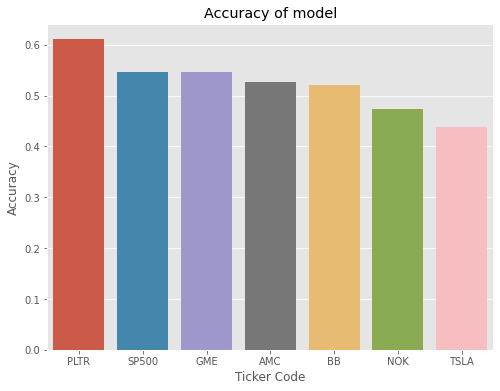

In [57]:
accuracy_df = accuracy_df.sort_values('Accuracy',ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=accuracy_df.index,y='Accuracy',data=accuracy_df)
plt.title('Accuracy of model')
plt.xlabel('Ticker Code')

Text(0.5, 0, 'Ticker Code')

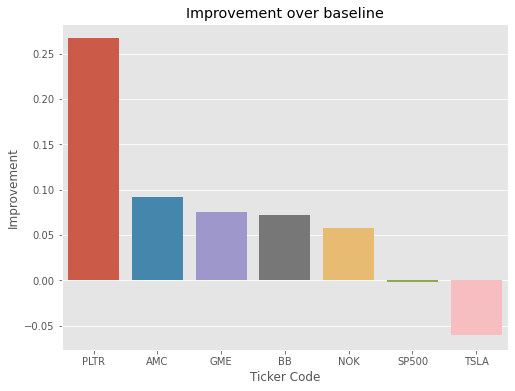

In [58]:
accuracy_df = accuracy_df.sort_values('Improvement',ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=accuracy_df.index,y='Improvement',data=accuracy_df)
plt.title('Improvement over baseline')
plt.xlabel('Ticker Code')

In [59]:
columns = stock_classification.X_train.columns


results_df = pd.DataFrame(np.array([
    list(results_dict[stocks[0]][2]),
    list(results_dict[stocks[1]][2]),
    list(results_dict[stocks[2]][2]),
    list(results_dict[stocks[3]][2]),
    list(results_dict[stocks[4]][2]),
    list(results_dict[stocks[6]][2]),
    ]), columns=columns, index=['SP500','GME','BB','AMC','NOK','TSLA'])

pltr_cols = testing_frames[5].drop(['up_tomorrow','date_string'],axis=1).columns

pltr = pd.DataFrame(np.array([list(results_dict[stocks[5]][2])]),columns=pltr_cols,index=['PLTR'])

results_df = pd.concat([results_df, pltr]).T

Text(0.5, 1.0, 'Results Heatmap')

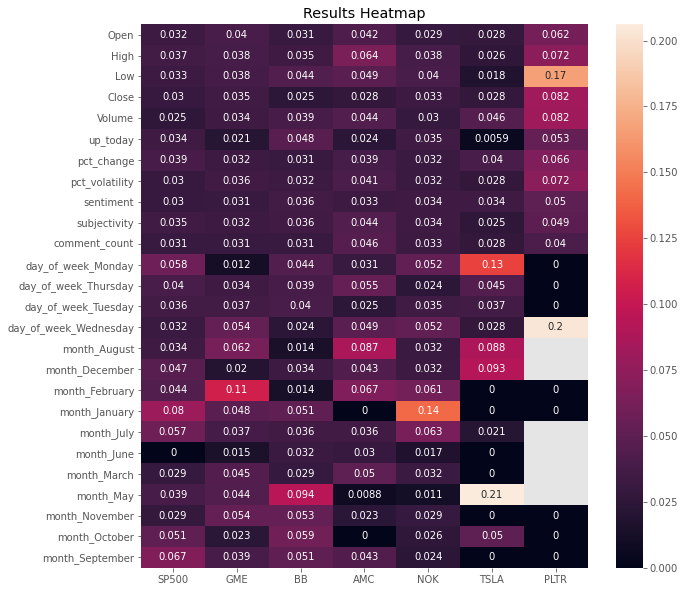

In [60]:
plt.figure(figsize=(10,10))
sns.heatmap(results_df, annot=True)
plt.title('Results Heatmap')